# Загрузка данных

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime as dt

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [69]:
# Загрузка данных
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')

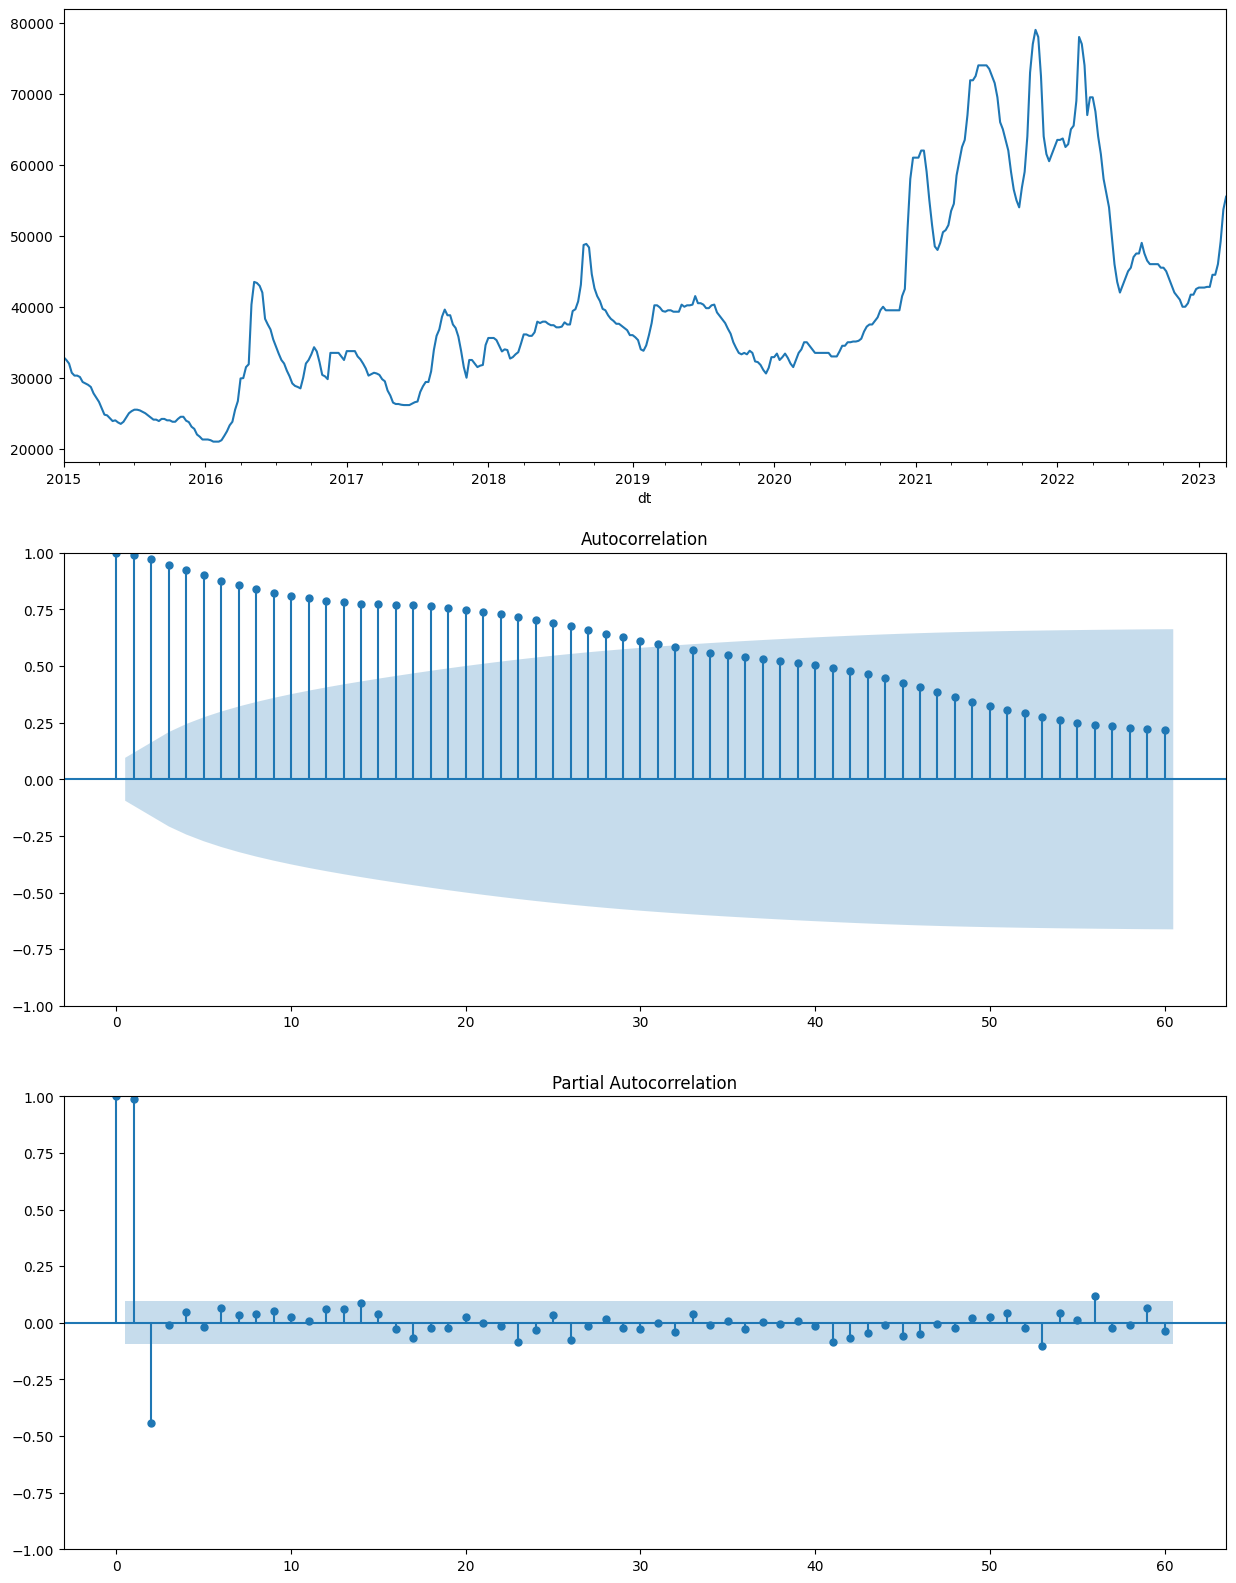

In [70]:
# вывод кореллограмм и ? (аргументировать зачем)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df['Цена на арматуру'], lags=60, ax=ax[2]);

In [71]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = df.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

# Модели

## catboost

In [73]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=['Цена на арматуру']), train['Цена на арматуру']
X_test, y_test = test.drop(columns=['Цена на арматуру']), test['Цена на арматуру']

for lag in [1, 2, 3, 6, 12]:
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

C:\Users\Илья\AppData\Local\Temp\ipykernel_19088\740552038.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
C:\Users\Илья\AppData\Local\Temp\ipykernel_19088\740552038.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
C:\Users\Илья\AppData\Local\Temp\ipykernel_19088\740552038.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [76]:
# Определяем модель
xgb_model = XGBRegressor()

# Подгоняем модель на данных
xgb_model.fit(X_train, y_train)

# Прогнозируем на тестовых данных
ygb_pred = xgb_model.predict(X_test)

# Оцениваем модель
mae = mean_absolute_error(y_test, ygb_pred)
r2 = r2_score(y_test, ygb_pred)
rmse = mean_squared_error(y_test, ygb_pred, squared=False)

print(f"MAE score: {mae}")
print(f"R2 score: {r2}")
print(f"RMSE score: {rmse}")

MAE score: 5810.4226471656975
R2 score: 0.5382542941114525
RMSE score: 7778.382043642669


C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [85]:
# Создание и обучение модели
cb_model = CatBoostRegressor(iterations=5000, 
                          learning_rate=0.01, 
                          depth=3, 
                          loss_function='MAE',
                          has_time=True,
                          early_stopping_rounds=100)

cb_model.fit(X_train, y_train)

# Прогнозирование
predictions = cb_model.predict(X_test)

# Оцениваем модель
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f"MAE score: {mae}")
print(f"R2 score: {r2}")
print(f"RMSE score: {rmse}")

0:	learn: 6659.4941523	total: 2.62ms	remaining: 13.1s
1:	learn: 6623.3779835	total: 3.69ms	remaining: 9.23s
2:	learn: 6587.4018648	total: 4.67ms	remaining: 7.78s
3:	learn: 6550.6399047	total: 5.7ms	remaining: 7.12s
4:	learn: 6506.7607772	total: 6.61ms	remaining: 6.61s
5:	learn: 6469.8985632	total: 7.42ms	remaining: 6.18s
6:	learn: 6424.5308033	total: 9.12ms	remaining: 6.5s
7:	learn: 6385.8855659	total: 10.4ms	remaining: 6.52s
8:	learn: 6340.8567305	total: 11.8ms	remaining: 6.55s
9:	learn: 6302.1027695	total: 12.6ms	remaining: 6.31s
10:	learn: 6261.2742229	total: 13.8ms	remaining: 6.24s
11:	learn: 6216.3581710	total: 15.2ms	remaining: 6.31s
12:	learn: 6181.6598151	total: 16.1ms	remaining: 6.19s
13:	learn: 6139.6136022	total: 17.2ms	remaining: 6.13s
14:	learn: 6107.7702051	total: 18.3ms	remaining: 6.08s
15:	learn: 6075.4424814	total: 19.4ms	remaining: 6.05s
16:	learn: 6046.9642607	total: 20.5ms	remaining: 6s
17:	learn: 6014.9305147	total: 21.6ms	remaining: 5.98s
18:	learn: 5987.5389659	t

C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [80]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet  # мета-модель
estimators = [
    ('cb', cb_model),
    ('XGB',xgb_model)
]
clf = StackingRegressor(
    estimators=estimators,
    final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7, random_state=42),  # ElasticNet
    cv=4
)
clf.fit(X_train,y_train)

0:	learn: 6656.3444447	total: 4.46ms	remaining: 22.3s
1:	learn: 6592.8328380	total: 9.1ms	remaining: 22.7s
2:	learn: 6554.0184045	total: 13.2ms	remaining: 21.9s
3:	learn: 6501.7488066	total: 17.2ms	remaining: 21.5s
4:	learn: 6439.9571712	total: 20.6ms	remaining: 20.5s
5:	learn: 6391.9201033	total: 24.3ms	remaining: 20.2s
6:	learn: 6341.3547523	total: 27.8ms	remaining: 19.9s
7:	learn: 6290.9586084	total: 32.7ms	remaining: 20.4s
8:	learn: 6248.7228689	total: 36.5ms	remaining: 20.3s
9:	learn: 6195.9632171	total: 40.5ms	remaining: 20.2s
10:	learn: 6150.3819954	total: 43.5ms	remaining: 19.7s
11:	learn: 6101.0620841	total: 47.9ms	remaining: 19.9s
12:	learn: 6056.1245925	total: 50.6ms	remaining: 19.4s
13:	learn: 6003.0114756	total: 53ms	remaining: 18.9s
14:	learn: 5960.9956906	total: 56.1ms	remaining: 18.6s
15:	learn: 5923.5157271	total: 58.8ms	remaining: 18.3s
16:	learn: 5883.4265043	total: 62.1ms	remaining: 18.2s
17:	learn: 5843.2909600	total: 65.6ms	remaining: 18.2s
18:	learn: 5812.9715287

StackingRegressor(cv=4,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x0000025DD3BC9BD0>),
                              ('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_p...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=ElasticNet(alpha=0.5, l1_ratio=0.7,
                                             random_state=42))

In [81]:
predictions = clf.predict(X_test)

In [82]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 16645.76
MSE: 403373661.78
RMSE: 20084.16
R²: -2.0784


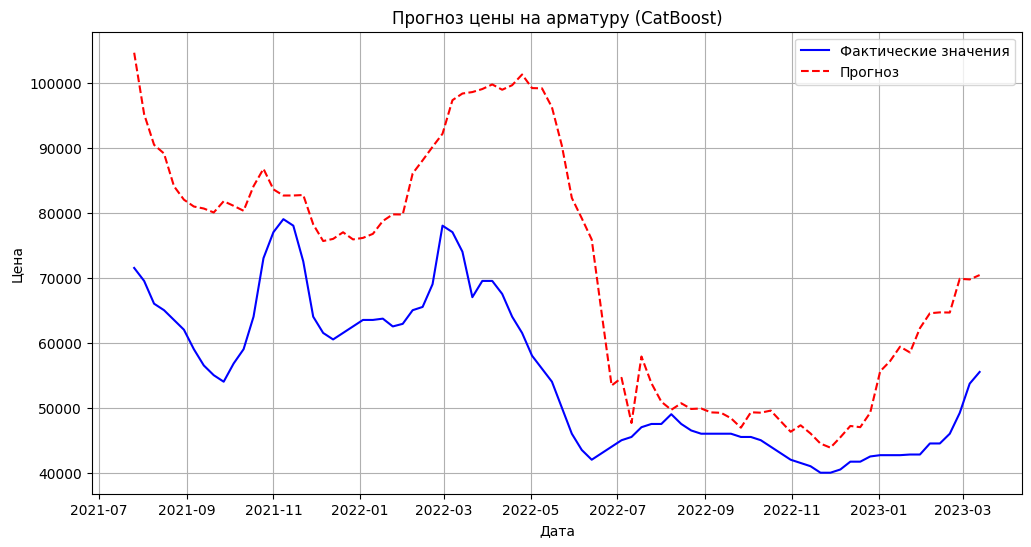

In [83]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Получаем важность признаков из модели
feature_importance = model.feature_importances_

# Сортируем индексы по убыванию важности
sorted_idx = np.argsort(feature_importance)[::-1]

# Выбираем топ-15 индексов
top_n = 10
top_feature_indices = sorted_idx[:top_n]

# Если исходный датасет — pandas.DataFrame
if isinstance(X_train, pd.DataFrame):
    # Получаем имена топ-признаков
    top_features = X_train.columns[top_feature_indices].tolist()
    # Создаем новый датасет с отобранными признаками
    X_selected = X_train[top_features]

# Если исходный датасет — numpy.ndarray
else:
    # Создаем новый датасет, выбирая столбцы по индексам
    X_selected = X_train[:, top_feature_indices]

print("Топ-15 признаков:", top_feature_indices)
X_selected

Топ-15 признаков: [10  2 27 43 11 15  4 13 12 25]


,"Лом_HMS 1/2 80:20, FOB США Восток, $/т","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","ГБЖ_CFR Италия, $/т",year,"Лом_3А, FOB РФ Черное море, $/т","Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_HMS 1/2 80:20, CFR ЮВА, $/т","Чугун_FOB Бразилия Север, $/т","Концентрат коксующегося угля_HCC Австралия, $/t FOB"
dt,,,,,,,,,,
2015-01-05,221.0,228.0,249.5,2015,221.0,11573.0,10009.0,248.0,338.0,106.0
2015-01-12,221.0,228.0,249.5,2015,221.0,11573.0,10009.0,248.0,338.0,106.0
2015-01-19,221.0,228.0,249.5,2015,221.0,11573.0,10009.0,248.0,338.0,106.0
2015-01-26,221.0,228.0,249.5,2015,221.0,11573.0,10009.0,248.0,338.0,106.0
2015-02-02,221.0,228.0,249.5,2015,221.0,11573.0,10009.0,248.0,338.0,106.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-21,461.0,463.0,520.0,2021,465.0,28202.0,27722.0,515.0,630.0,201.0
2021-06-28,459.0,457.0,517.5,2021,462.0,27807.0,26673.0,513.0,615.0,211.0
2021-07-05,459.0,456.0,517.5,2021,460.0,26924.0,25813.0,518.0,615.0,220.0


In [ ]:
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=100)

0:	learn: 6656.3444447	test: 21089.9069787	best: 21089.9069787 (0)	total: 4.64ms	remaining: 23.2s
1:	learn: 6592.8328380	test: 20894.8745412	best: 20894.8745412 (1)	total: 7.13ms	remaining: 17.8s
2:	learn: 6554.0184045	test: 20853.0662441	best: 20853.0662441 (2)	total: 10.8ms	remaining: 18s
3:	learn: 6501.7488066	test: 20679.3171145	best: 20679.3171145 (3)	total: 13.4ms	remaining: 16.7s
4:	learn: 6439.9571712	test: 20475.6051407	best: 20475.6051407 (4)	total: 15.8ms	remaining: 15.8s
5:	learn: 6391.9201033	test: 20436.3638654	best: 20436.3638654 (5)	total: 18.1ms	remaining: 15.1s
6:	learn: 6341.3547523	test: 20363.6895620	best: 20363.6895620 (6)	total: 20.4ms	remaining: 14.5s
7:	learn: 6290.9586084	test: 20185.6303658	best: 20185.6303658 (7)	total: 23.4ms	remaining: 14.6s
8:	learn: 6248.7228689	test: 20133.3923833	best: 20133.3923833 (8)	total: 27.3ms	remaining: 15.2s
9:	learn: 6195.9632171	test: 19887.0682454	best: 19887.0682454 (9)	total: 30ms	remaining: 15s
10:	learn: 6150.3819954	te

In [ ]:
predictions = model.predict(X_test)

In [ ]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 5127.09
MSE: 47169583.62
RMSE: 6868.01
R²: 0.6400


In [ ]:
import pickle
with open('catboost_model.pkl', 'wb') as f: pickle.dump(model, f)